In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell

# Hyperparameters

In [2]:
sec_per_ar = 2
ar_per_sec = 1/sec_per_ar
time_length = 300
discount_rate = 0.95
rnn_size = 10
test_length = 700

# Load patient ar_data

In [3]:
folder_path = '/home/maestoj/medical_analysis/ar/'

In [4]:
def ar_data_load(patient_number,data_set_number):
    file_name = "data_patient_{}_AR{}.csv".format(patient_number,data_set_number)
    file_path = folder_path+file_name
    ar_file = open(file_path,'r',newline='')
    reader = csv.reader(ar_file, delimiter= ',')
    temp = []
    for row in reader:
        temp.append(row)
    temp = np.array(temp, dtype = np.float32)
    print("{} is loaded from {}".format(file_name, file_path))
    return temp

In [5]:
def ar_data_sum_channels(ar_datas):
    a, b = ar_datas.shape
    temp = np.zeros(b)
    for i in range(b):
        for j in range(a):
            temp[i] += ar_datas[j][i]
    return temp

In [6]:
def ar_data_select_channel(ar_datas, channel_number):
    return ar_datas[channel_number - 1]

In [7]:
def normalizer(array):
    temp_max = np.max(array)
    temp_min = np.min(array)
    temp = np.zeros(len(array))
    for i in range(len(array)):
        temp[i] = (array[i]-temp_min)/(temp_max-temp_min)
    return temp

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv


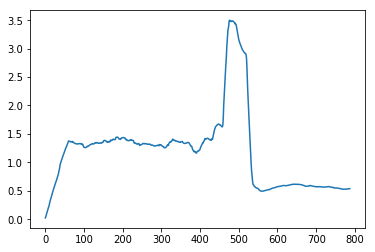

In [8]:
plt.plot(ar_data_sum_channels(ar_data_load(1,1)))
plt.show()

# Onset-time data

In [9]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [10]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1

for p in range(total_patient):
    temp = []
    for d in range(event_number[p]):
        temp.append(seizure_time_parser(onset_times_temp,p+1,d+1))
    onset_times.append(temp)

In [11]:
print("The number of datasets of patients")
print(event_number)
print("1st patient's seizure time for each data_set")
print(onset_times[0])
print("9th patient's seizure time for each data_set")
print(onset_times[8])

The number of datasets of patients
[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]
1st patient's seizure time for each data_set
[array([820]), array([781]), array([626]), array([713]), array([807]), array([792]), array([780])]
9th patient's seizure time for each data_set
[array([200]), array([312]), array([624]), array([762]), array([752]), array([772]), array([884]), array([502]), array([ 94, 258]), array([836]), array([650]), array([636]), array([576]), array([656]), array([638]), array([706])]


# Training_set

In [12]:
def train_set_generator(patient_number, dataset_number, channel_number):
    
    temp = normalizer(ar_data_select_channel(ar_data_load(patient_number, dataset_number), channel_number))
    
    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        


    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    
    onset_time_temp = onset_time_temp[0]
    print(onset_time_temp)
    
    if onset_time_temp*ar_per_sec < time_length:
        print("Wrong input")
        return
    
    input_data = np.zeros(time_length)
    output_data = np.zeros(time_length)
    for i in range(time_length):
        if i==0:
            output_data[time_length-1] = 1
        else :
            output_data[time_length-1-i] = discount_rate*output_data[time_length-i] 

    onset_on_ar = int(onset_time_temp*ar_per_sec)
    for i in range(time_length):
        input_data[i] = temp[onset_on_ar-time_length+1+i]

    return {'input' : input_data, 'output' : output_data}

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


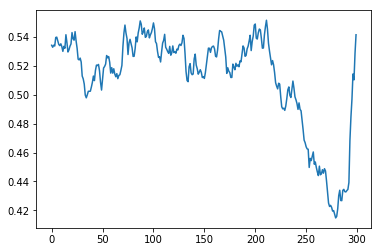

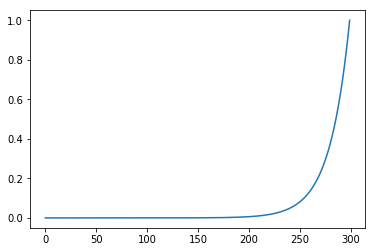

(300,)
(300,)


In [13]:
result = train_set_generator(1,1,1)
plt.plot(result['input'])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

# Neural network

In [14]:
x = tf.placeholder(tf.float32, shape=[time_length])
y = tf.placeholder(tf.float32, shape=[time_length])
test_x = tf.placeholder(tf.float32, shape=[test_length])

rnn_tei_x = tf.reshape(test_x,[test_length,1])
rnn_tei_x = tf.split(0,test_length,rnn_tei_x)

rnn_tri_x = tf.reshape(x,[time_length,1])
rnn_tri_x = tf.split(0,time_length,rnn_tri_x)

with tf.variable_scope("rnn") as scope:
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
    W = tf.Variable(tf.truncated_normal([rnn_size,1], stddev=0.01))
    b = tf.Variable(tf.constant(0.01, shape=[1]))
    initial_state = lstm_cell.zero_state(1, tf.float32)
    outputs, states = rnn.rnn(lstm_cell, inputs = rnn_tri_x, initial_state = initial_state, dtype=tf.float32)
    temp_outputs = tf.pack(outputs)
    temp_outputs = tf.reshape(temp_outputs,[-1,rnn_size])
    temp_outputs = tf.matmul(temp_outputs,W)+b
    print(temp_outputs)
    scope.reuse_variables()
    test_outputs, test_states = rnn.rnn(lstm_cell, inputs = rnn_tei_x, initial_state = initial_state, dtype =tf.float32)
    temp_test_outputs = tf.pack(test_outputs)
    temp_test_outputs = tf.reshape(temp_test_outputs, [-1,rnn_size])
    temp_test_outputs = tf.matmul(temp_test_outputs,W)+b
    print(temp_test_outputs)
    temp_y = tf.reshape(y, [-1,1])
    print(temp_y)

Tensor("rnn/add:0", shape=(300, 1), dtype=float32)
Tensor("rnn/add_1:0", shape=(700, 1), dtype=float32)
Tensor("rnn/Reshape_2:0", shape=(300, 1), dtype=float32)


In [15]:
cost = tf.reduce_sum(tf.square(temp_outputs-temp_y))
train = tf.train.AdamOptimizer(1e-3).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
train_data_set = []
temp_train_data_set = [1,6,8,9,10,11,12,14,15,16,17,18]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,8,9,10,16,17]
train_data_set.append(temp_train_data_set)
print(train_data_set)

[[1, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18], [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21], [1, 8, 9, 10, 16, 17]]


data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


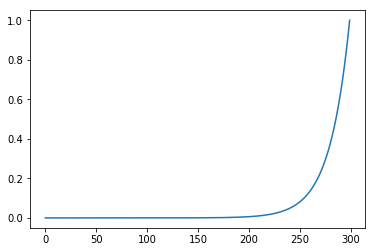

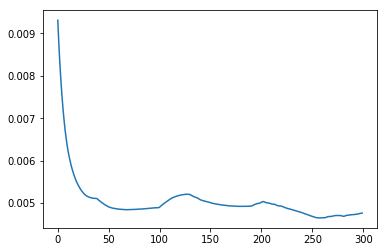

Cost = 10.075125694274902
Cost = 8.679587364196777
Cost = 8.092463493347168
Cost = 0.9614680409431458
Cost = 0.2988145649433136
Cost = 0.21923688054084778
Cost = 0.1986578404903412
Cost = 0.17114093899726868
Cost = 0.17127884924411774
Cost = 0.15475094318389893
Cost = 0.1495908498764038


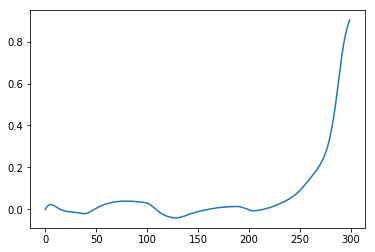

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


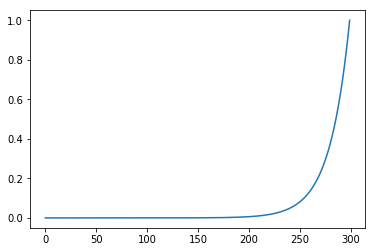

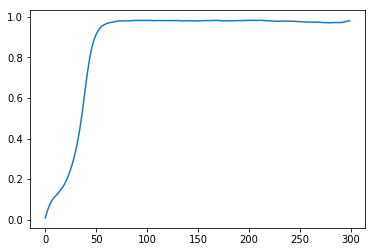

Cost = 219.79901123046875
Cost = 9.562755584716797
Cost = 9.422544479370117
Cost = 9.302164077758789
Cost = 9.17786693572998
Cost = 9.012027740478516
Cost = 8.525814056396484
Cost = 8.160611152648926
Cost = 6.894680023193359
Cost = 0.39661478996276855
Cost = 0.24553358554840088


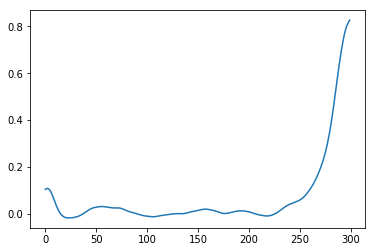

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


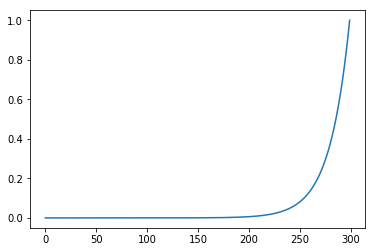

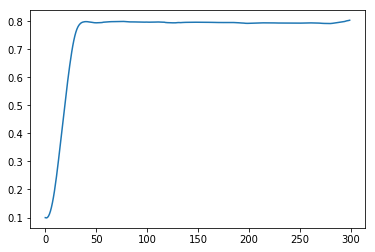

Cost = 154.87806701660156
Cost = 8.777527809143066
Cost = 8.7494535446167
Cost = 8.703465461730957
Cost = 8.608611106872559
Cost = 8.136558532714844
Cost = 3.421452522277832
Cost = 0.9727660417556763
Cost = 0.45278364419937134
Cost = 0.3951956331729889
Cost = 0.5085328817367554


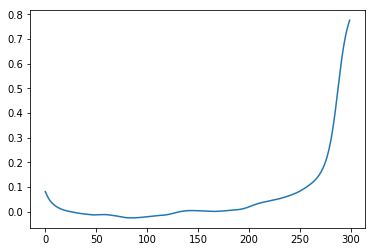

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


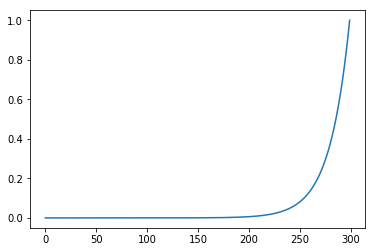

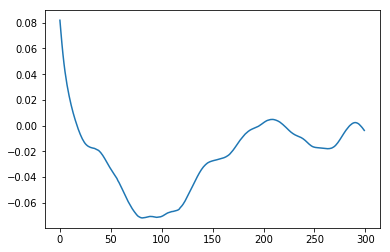

Cost = 10.851469039916992
Cost = 8.944549560546875
Cost = 8.937104225158691
Cost = 8.932950973510742
Cost = 8.928634643554688
Cost = 8.924150466918945
Cost = 8.919493675231934
Cost = 8.914657592773438
Cost = 8.909637451171875
Cost = 8.904423713684082
Cost = 8.899011611938477


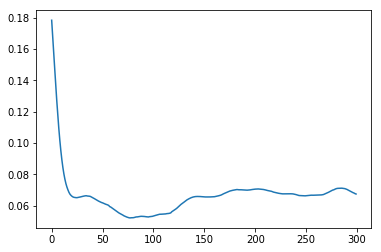

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


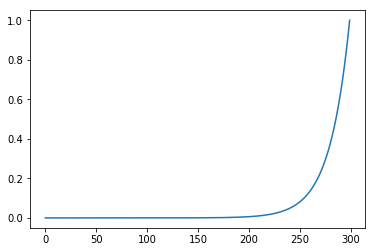

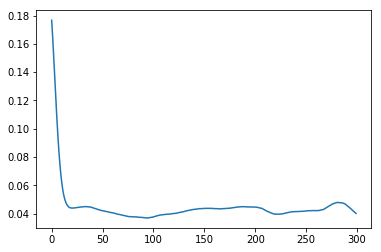

Cost = 9.164670944213867
Cost = 9.012264251708984
Cost = 9.008776664733887


KeyboardInterrupt: 

In [17]:
for a in range(len(train_data_set)):
    for b in range(len(train_data_set[a])):
        result = train_set_generator(1, a+1, b)
        input_data = result['input']
        output_data =result['output']
        plt.plot(output_data)
        plt.show()
        plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
        plt.show()
        for i in range(1001):
            opt, c = sess.run([train, cost], feed_dict={x: input_data, y: output_data})
            if i%100==0:
                print("Cost = {}".format(c))
        plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
        plt.show()

# Test_set_generator

In [ ]:
def test_set_generator(patient_number, dataset_number, channel_number):
    
    temp = normalizer(ar_data_select_channel(ar_data_load(patient_number, dataset_number), channel_number))

    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        
    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    onset_time_temp = onset_time_temp[0]
    print(onset_time_temp)
    input_data = np.zeros(test_length)
    time = np.zeros(test_length)
    for i in range(test_length):
        input_data[i] = temp[60+i]
        time[i] = (60+i)*sec_per_ar
    return {'input' : input_data, 'time' : time}

In [ ]:
result = test_set_generator(1, 1, 1)
input_data = result['input']
time =result['time']
plt.plot(time, input_data)
plt.show()
plt.plot(time, sess.run(temp_test_outputs, feed_dict = {test_x : input_data}))
plt.show()

In [ ]:
patient_number = 9
dataset_number = 5

temp = dataload(patient_number, dataset_number)
nchannels = temp.shape[0]
onset_times_temp = onset_times[patient_number-1][dataset_number-1]

flag = 0

for channel_number in range(nchannels):
    result = test_set_generator(temp,onset_times_temp,channel_number)
    val_input = result['input']
    val_output = result['output']

    if flag==0:
        flag=1
        time_step_size = striding/sampling_rate
        time = np.zeros(val_input.shape[0])
        for i in range(len(time)):
            time[i] = (i + data_size)*time_step_size   
        plt.plot(time, val_output)
        plt.title("Seizure_time_output(patient {}, event {})"
                    .format(patient_number,dataset_number))
        plt.set_xlabel('sec')
        plt.vlines(onset_times[patient_number-1][dataset_number-1],0,1.5, color='r'
                   , alpha=0.9, linestyle='--', label='Onsets')
        plt.show()

    prediction = sess.run(y_predict, feed_dict={x: val_input})
    plt.plot(time, prediction)
    plt.title("Prediction(patient {}, event {}, Channel {})"
                .format(patient_number,dataset_number,channel_number))
    plt.set_xlabel('sec')
    plt.show()